# E-shop data modelling

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

Read the _.csv_ file

In [2]:
raw_data = pd.read_csv("e-shop clothing 2008.csv", sep=";")
raw_data.head()

,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page
0,2008,4,1,1,29,1,1,A13,1,5,1,28,2,1
1,2008,4,1,2,29,1,1,A16,1,6,1,33,2,1
2,2008,4,1,3,29,1,2,B4,10,2,1,52,1,1
3,2008,4,1,4,29,1,2,B17,6,6,2,38,2,1
4,2008,4,1,5,29,1,2,B8,4,3,2,52,1,1


## Exploratory Data Analysis

### On Price (Response variable)

We start by counting how many null files the dataset contains while also looking at some general statistics regarding the response variable _price_.

In [3]:
print("Number of nulls within the data: ", raw_data.isnull().values.sum())
print("Statistics regarding the price, the response variable: ")
print('')
print(raw_data.price.describe())
print('')
within2std = raw_data[raw_data['price']>43.802507+(2*12.548131)].shape[0]
within2std = within2std + raw_data[raw_data['price']<43.802507-(2*12.548131)].shape[0]

within3std = raw_data[raw_data['price']>43.802507+(3*12.548131)].shape[0]
within3std + within3std + raw_data[raw_data['price']<43.802507-(3*12.548131)].shape[0]

print('')
print('How many entries have price within 2 standard deviations to the mean:')
print(within2std)
print(within2std/raw_data.shape[0] * 100, '% of the data')
print('')

print('How many entries have price within 3 standard deviations to the mean:')
print(within3std)
print(within3std/raw_data.shape[0] * 100, '% of the data')
raw_data['year'].unique()

Number of nulls within the data:  0
Statistics regarding the price, the response variable: 

count    165474.000000
mean         43.802507
std          12.548131
min          18.000000
25%          33.000000
50%          43.000000
75%          52.000000
max          82.000000
Name: price, dtype: float64


How many entries have price within 2 standard deviations to the mean:
4319
2.610077716136674 % of the data

How many entries have price within 3 standard deviations to the mean:
1923
1.1621161028318647 % of the data


array([2008], dtype=int64)

Looking at the distribution of price. According to the plot, the variable seems categorical. However, this should not be the case with price. There is no indication that future products will be within the given price values and thus we should consider a continuous case.

[28 33 52 38 57 48 67 43 62 26 20 72 50 18 82 23 65 60 77 55]


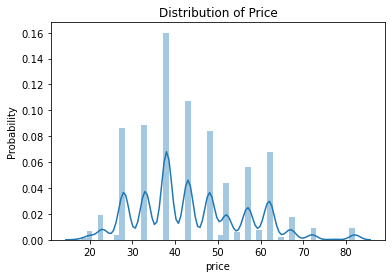

In [4]:
ax = sns.distplot(raw_data.price)
ax.set_title('Distribution of Price')
ax.set_ylabel('Probability')
print(raw_data.price.unique())

### On Features
Our aim is to build a predictor that predicts the price of the model. According to the description file, the variable 'page 2 (clothing model)' identifies the product and thus we can consider it as the key of what we want to predict. However, to avoid false assumption we will count how many distinct products there are for a given model.

In order to do this, we fetch only the columns that define a product from the dataset while we omit columns that deal purely with the purchase. The columns used are: _page 1 (main category), colour, location, model photography, price, page_. (Price 2 is redundant since we know price).

In [5]:
rr = raw_data[['page 1 (main category)', 'colour', 'location', 'model photography', 'price', 'page', 'page 2 (clothing model)']]
group = rr.groupby(['page 2 (clothing model)'])
for i in group.groups.keys():
    gp = group.get_group(i)
    if gp.drop_duplicates().shape[0] > 1:
        print('The model',i, 'represents multiple products.')


The model A18 represents multiple products.


In [6]:
print('Duplicate instances given A18')
print('')
print('Color:',group.get_group('A18').colour.unique().shape[0])
print('Location:',group.get_group('A18').location.unique().shape[0])
print('Price:',group.get_group('A18').price.unique().shape[0])
print('Model Photography:',group.get_group('A18')['model photography'].unique().shape[0])
print('Page:',group.get_group('A18').page.unique().shape[0])
print('Page1 (main category):',group.get_group('A18')['page 1 (main category)'].unique().shape[0])

Duplicate instances given A18

Color: 1
Location: 1
Price: 1
Model Photography: 1
Page: 1
Page1 (main category): 2


In [7]:
group = rr.groupby(['page 2 (clothing model)', 'page 1 (main category)'])
print(group.get_group(('A18',1)).shape[0])
print(group.get_group(('A18',2)).shape[0])

937
1


There is only a single instance of the duplicated model code. Thus, we remove it on data cleaning.

### Correlation

The dataset contains both categorical and ordinal data. <br>
**Ordinal:** Day, Month, Order, Session ID, location, page. <br> 
**Categorical:** Country, Page 1 (main category), Page 2 (clothing model), colour, model photography. <br> <br>

Note that some data such as day and month may seem unrelated with the product itself but it is worth exploring them before discarding. For instance, customers may prefer to buy expensive products at the beginning of the month when they get paid or some products are related with a specific month of the calendar.

Text(0.5, 1.0, 'Spearman correlation between ordinal features and price.')

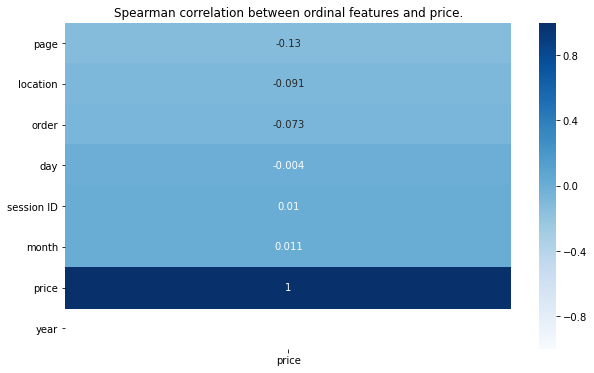

In [8]:
raw_data_ordinal = raw_data[['day','month', 'year','order', 'session ID', 'location', 'page','price']]
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.heatmap(raw_data_ordinal.corr('spearman')[['price']].sort_values('price').head(20),
 vmax=1, vmin=-1, cmap='Blues', annot=True, ax=ax);
ax.set_title('Spearman correlation between ordinal features and price.')

Year is not tagged. Explore further:

In [9]:
raw_data.year.unique()

array([2008], dtype=int64)

There is only a single year recorded. It does not affect prediction thus we can drop it.

Text(0.5, 1.0, 'Correlations between features.')

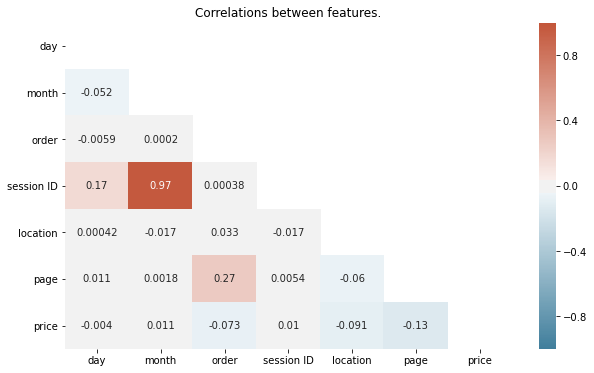

In [10]:
raw_data_ordinal = raw_data_ordinal.drop(columns=['year'])
corr = raw_data_ordinal.corr('spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(10,6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
ax = sns.heatmap(corr, mask = mask, cmap=cmap,
 vmax=1, vmin=-1,  annot=True, ax=ax);
ax.set_title('Correlations between features.')

The above indicates that there is low relation between price and the ordinal values. We will discard _day, session ID and month_ since these three scored the lowest absolute score. <br>
<br>
High correlation between _month_ and _session ID_ which is expected since the data recorded is of a single year. There is some relation between page and order which is again expected, pages other than the main page require clicks.

**Further statistics of _page_ which scored the highest correlation with price:**

Different value that page can take:
[1 4 5 2 3]
Size of each group:
1 93452
2 41037
3 19301
4 8861
5 2823


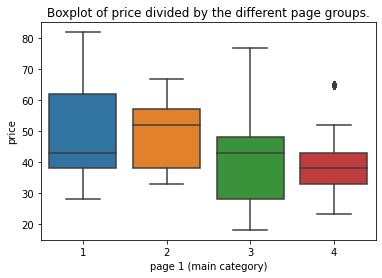

In [11]:
print("Different value that page can take:")
print(raw_data['page'].unique())
ax=sns.boxplot(x ='page 1 (main category)', y ='price', data = raw_data)
ax.set_title('Boxplot of price divided by the different page groups.')

gb = raw_data.groupby(['page'])
print('Size of each group:')
for i in gb.groups.keys():
    cg=gb.get_group(i)
    print(i,cg.shape[0])


Overall, products bought from the second page are more expensive. In the same page, it is to find products of the same price range. The reason for this may be that in page 2 there are the most products and the whole collection is reflected more. 

In contrast, page 4 offers a smaller variety and there are a few clothes which are more expensive compared to the rest within the page.

### Categories

Again some variables such as countries might not make sense but we cannot disregard them with no proof. People from a specific country might have a more expensive taste. <br>
We will create dummy variables for each categorical data we find to be valuable for our model.
<br>
As a first step, we will calculate the standard deviation of every value in the category with respect to price.

In [12]:
categories = ['country', 'page 1 (main category)', 'colour', 'model photography']

subgroups_var = pd.DataFrame(columns = ['category','value','std','len'])
for i in categories:
    group = raw_data.groupby(i)

    for j in group.groups.keys():
        subgroups_var = subgroups_var.append({'category' : i, 'value' : j, 'std' : np.std(group.get_group(j).price), 'len' : group.get_group(j).shape[0]}, 
               ignore_index = True) 
print(subgroups_var.shape[0])
subgroups_var.sort_values(['std'], ascending = 1).tail(20)


67


,category,value,std,len
1,country,2,12.552008,58
65,model photography,1,12.563742,122439
45,country,46,12.566225,2522
13,country,14,12.675379,43
23,country,24,12.784374,4091
14,country,15,12.896620,125
26,country,27,12.968383,227
4,country,5,13.009612,4
43,country,44,13.026954,1385
15,country,16,13.069510,834


Certain values achieve high standard deviation, even higher than the standard deviation of the dataset. However, there are only 67 values for all categories. Replacing the above categories with 67 dummy variables is withing our processing power. 

## Dataset preparation

No nulls found. No strings to deal with spaces, lower case, punctuation etc. No outliers, max value for price is just 82. Only thing to do: Remove the extra value of the A18 clothing model. 

In [13]:
raw_data = raw_data.drop(raw_data[(raw_data['page 2 (clothing model)'] == 'A18') & (raw_data['page 1 (main category)'] == 2)].index)
#raw_data = raw_data.reset_index()

### Convert categorical data dummy variables 

Remove year, month, day and session ID as discussed. Also remove page 2 (clothing model) and price 2 since these two are directly related to the response variable

In [14]:
input_data = pd.get_dummies(raw_data, columns=['page 1 (main category)', 'colour', 'model photography','country'])
input_data = input_data.drop(columns = ['year', 'month', 'day', 'session ID', 'price 2', 'page 2 (clothing model)'])

In [15]:
input_data

,order,location,price,page,page 1 (main category)_1,page 1 (main category)_2,page 1 (main category)_3,page 1 (main category)_4,colour_1,colour_2,...,country_38,country_39,country_40,country_41,country_42,country_43,country_44,country_45,country_46,country_47
0,1,5,28,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,6,33,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,52,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,6,38,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3,52,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165469,1,4,67,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
165470,1,4,62,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165471,1,1,43,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
165472,2,1,43,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Selection

We are usig chi2 to discover which features are more valuable with respect to price.

In [16]:
x = input_data.drop(columns = ['price'])
y = input_data['price']

fs = SelectKBest(score_func = chi2, k ='all')
fs.fit(x,y)
X_fs = fs.transform(x)

for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 30435.679427
Feature 1: 22919.502460
Feature 2: 10389.779829
Feature 3: 35668.681579
Feature 4: 56497.292354
Feature 5: 43004.860754
Feature 6: 21584.540566
Feature 7: 5646.929173
Feature 8: 15328.425477
Feature 9: 36117.247052
Feature 10: 14300.752562
Feature 11: 8244.119888
Feature 12: 7731.476128
Feature 13: 8000.975503
Feature 14: 15220.068470
Feature 15: 19773.673249
Feature 16: 60245.535726
Feature 17: 15250.194526
Feature 18: 17998.454750
Feature 19: 14433.629710
Feature 20: 12496.000872
Feature 21: 4551.115325
Feature 22: 12948.285305
Feature 23: 6.532089
Feature 24: 24.462928
Feature 25: 40.941669
Feature 26: 3.883803
Feature 27: 5.166184
Feature 28: 14.325948
Feature 29: 4.425643
Feature 30: 40.451152
Feature 31: 1154.240475
Feature 32: 58.108110
Feature 33: 29.717864
Feature 34: 23.315058
Feature 35: 12.546438
Feature 36: 44.173462
Feature 37: 18.743855
Feature 38: 37.629901
Feature 39: 28.203537
Feature 40: 8.638033
Feature 41: 39.417904
Feature 42: 92.812058
Fea

For Features 23-69, the score decreases significantly. Note that, features 23-69 are the country dummy variables. As a result, we choose to disregard countries in the given problem.

In [17]:
X_fs = X_fs[:,0:22]

## Model
<br>We will use ridge linear regression with regularisation. <br>
How we proceed:<br>
1. Split the sample to two: training_testing and validation sets.
2. Define a range of possible regularisation parameters: from -20 to 20 with step 0.5.
3. Implement cross validation on the training_testing set: On each iteration calculate the R2 score achieved.
4. Calculate the average R2 score per regularisation paramter.
5. Feed the data of training_testing set to a new Ridge regression model with the regularisation parameter achieved.
6. Calculate the R2 score achived on the validation set.

In [18]:
from sklearn.model_selection import train_test_split

y = np.array(y)
X_train_test, X_valid, y_train_test, y_valid = train_test_split(X_fs,y,test_size=0.20,random_state=10)

#
# y_train_test.reset_index()
# y_valid.reset_index()

kf = StratifiedKFold(n_splits=10, random_state=0)
errors = []

scores = {}
for i in np.arange(-20,20,0.5):
    clf = Ridge(alpha=i)
    error_per_reg_param = []
    for train_index,test_index in kf.split(X_train_test,y_train_test):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X_train_test[train_index], X_train_test[test_index]
        y_train, y_test = y_train_test[train_index], y_train_test[test_index]
        clf.fit(X_train,y_train)
        y_predicted =clf.predict(X_test)
        r2 = r2_score(y_test,y_predicted)
       # rmse = sqrt(mean_squared_error(y_test, y_predicted))
        error_per_reg_param.append(r2)
    scores[i] = np.mean(np.array(r2))

reg_param = max(scores, key=scores.get)
clf = Ridge(alpha=reg_param)
clf.fit(X_train_test,y_train_test)
y_predicted = clf.predict(X_valid)
print('R2 score of final model:', r2_score(y_valid,y_predicted))

R2 score of final model: 0.3179533105556034
